In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import os
import matplotlib.pyplot as plt


CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = 10

# --- 1. Google Colab Setup (Mount Drive for Persistence and Backup) ---

def mount_google_drive():
    """Mounts Google Drive and sets up save directories."""
    try:
        from google.colab import drive
        print("--- Attempting to Mount Google Drive ---")
        drive.mount('/content/drive')
        print("Google Drive mounted successfully.")
    except ImportError:
        print("Not running in Colab environment. Skipping Google Drive mount.")

# Execute mount command
mount_google_drive()

# Define paths for saving artifacts
# BackupAndRestore saves the ENTIRE state (including optimizer and epoch count)
BACKUP_DIR = "/content/drive/MyDrive/densenet_cifar10_backup_model_2"
# ModelCheckpoint saves only the BEST weights
MODEL_SAVE_DIR = '/content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/'
# Updated model name
MODEL_NAME = 'densenet121_cifar10_model_2best.h5'
CHECKPOINT_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_NAME)

# Ensure backup and checkpoint directories exist
os.makedirs(BACKUP_DIR, exist_ok=True)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"\nBackup Directory: {BACKUP_DIR}")
print(f"Best Model Checkpoint Path: {CHECKPOINT_PATH}")


--- Attempting to Mount Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.

Backup Directory: /content/drive/MyDrive/densenet_cifar10_backup_model_2
Best Model Checkpoint Path: /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


In [2]:
# --- 2. Data Loading and Preprocessing ---

# Logic from load_and_preprocess_cifar10()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"\nOriginal Input Shape: {x_train.shape}")

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, NUM_CLASSES)
y_test_one_hot = to_categorical(y_test, NUM_CLASSES)

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# y_test_int contains the original integer labels [0, 1, 2, ...]
y_test_int = y_test


Original Input Shape: (50000, 32, 32, 3)


In [5]:
# Data Augmentation Setup
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

In [6]:
# --- 3. Model Definition and Upscaling ---

# Logic from build_densenet121_model() - Defining the Keras Model directly

INPUT_SHAPE = (32, 32, 3)
TARGET_SHAPE = (224, 224, 3) # Required by DenseNet ImageNet weights
SCALE_FACTOR = 7 # 32 * 7 = 224

# 1. Input layer (takes the original 32x32 CIFAR image)
img_input = Input(shape=INPUT_SHAPE)

# 2. Upscaling layer (CRUCIAL for ImageNet weights on CIFAR-10)
x = UpSampling2D(size=(SCALE_FACTOR, SCALE_FACTOR), interpolation='bilinear', name='upscale_layer')(img_input)

# 3. DenseNet-specific preprocessing
x = tf.keras.applications.densenet.preprocess_input(x, data_format=None)

# 4. Base Model (DenseNet121 pre-trained on ImageNet)
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=x,
    input_shape=TARGET_SHAPE,
    pooling=None,
    name='densenet121_base'
)

# Freeze the layers of the base model initially
base_model.trainable = False

# 5. New Classification Head for CIFAR-10
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = Model(inputs=img_input, outputs=x, name="densenet_cifar10_finetune")


# --- 4. Callbacks and Training Preparation (Two-Phase Strategy) ---

callbacks = [
    # 1. BACKUP AND RESTORE (Training Resilience)
    tf.keras.callbacks.BackupAndRestore(
        backup_dir=BACKUP_DIR
    ),

    # 2. MODEL CHECKPOINT (Best Weights Backup)
    ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # 3. EARLY STOPPING
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1
    )
]

In [7]:
# Compile Phase 1
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*50)
print("PHASE 1: FEATURE EXTRACTION (Training New Head)")
print("="*50)

# Train Phase 1
history_phase1 = model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=64),
    epochs=10,
    validation_data=(x_test, y_test_one_hot),
    callbacks=callbacks,
    verbose=1
)


PHASE 1: FEATURE EXTRACTION (Training New Head)
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1250 - loss: 2.2989
Epoch 1: val_accuracy improved from -inf to 0.16620, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 141ms/step - accuracy: 0.1250 - loss: 2.2988 - val_accuracy: 0.1662 - val_loss: 2.1670
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1910 - loss: 2.1505
Epoch 2: val_accuracy improved from 0.16620 to 0.18780, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.1910 - loss: 2.1505 - val_accuracy: 0.1878 - val_loss: 2.1658
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2279 - loss: 2.0363
Epoch 3: val_accuracy improved from 0.18780 to 0.23250, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.2279 - loss: 2.0362 - val_accuracy: 0.2325 - val_loss: 2.0282
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2616 - loss: 1.9552
Epoch 4: val_accuracy improved from 0.23250 to 0.25840, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.2616 - loss: 1.9552 - val_accuracy: 0.2584 - val_loss: 2.0104
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2716 - loss: 1.9142
Epoch 5: val_accuracy improved from 0.25840 to 0.28000, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.2716 - loss: 1.9142 - val_accuracy: 0.2800 - val_loss: 1.9418
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2875 - loss: 1.8894
Epoch 6: val_accuracy improved from 0.28000 to 0.29850, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.2875 - loss: 1.8894 - val_accuracy: 0.2985 - val_loss: 1.9189
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2996 - loss: 1.8680
Epoch 7: val_accuracy improved from 0.29850 to 0.32180, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.2996 - loss: 1.8680 - val_accuracy: 0.3218 - val_loss: 1.8507
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3081 - loss: 1.8475
Epoch 8: val_accuracy improved from 0.32180 to 0.34750, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.3081 - loss: 1.8475 - val_accuracy: 0.3475 - val_loss: 1.7850
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3234 - loss: 1.8256
Epoch 9: val_accuracy did not improve from 0.34750
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 87ms/step - accuracy: 0.3234 - loss: 1.8256 - val_accuracy: 0.3098 - val_loss: 1.8983
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3233 - loss: 1.8160
Epoch 10: val_accuracy improved from 0.34750 to 0.34950, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.3233 - loss: 1.8160 - val_accuracy: 0.3495 - val_loss: 1.7809


In [10]:
# CRUCIAL FIX: Globally unfreeze the base layer first
# base_model is a Keras Model instance, so we set its trainable status
base_model.trainable = True

# Define the number of initial layers to keep FROZEN (generic feature extractors)
FREEZE_FIRST_N_LAYERS = 50

print(f"Total layers in DenseNet121 base: {len(base_model.layers)}")
print(f"Freezing the first {FREEZE_FIRST_N_LAYERS} layers and unfreezing the rest for fine-tuning...")

# Loop through the layers of the base model (using 'base_model' variable)
for i, layer in enumerate(base_model.layers):
    if i < FREEZE_FIRST_N_LAYERS:
        # Freeze the first N layers (generic features)
        layer.trainable = False
    else:
        # Unfreeze the remaining, deeper layers (task-specific features)
        layer.trainable = True

# Re-compile the model with a much lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*50)
print("PHASE 2: FINE-TUNING (Selective Unfreeze: Freeze First 50 Layers)")
print("="*50)

# Train Phase 2
history_phase2 = model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=32),
    epochs=30,
    validation_data=(x_test, y_test_one_hot),
    callbacks=callbacks,
    verbose=1
)

Total layers in DenseNet121 base: 428
Freezing the first 50 layers and unfreezing the rest for fine-tuning...

PHASE 2: FINE-TUNING (Selective Unfreeze: Freeze First 50 Layers)
Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2631 - loss: 17.0225
Epoch 1: val_accuracy improved from 0.34950 to 0.44260, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 419s 174ms/step - accuracy: 0.2631 - loss: 17.0160 - val_accuracy: 0.4426 - val_loss: 1.6158
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4636 - loss: 1.4923
Epoch 2: val_accuracy improved from 0.44260 to 0.54420, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 104ms/step - accuracy: 0.4637 - loss: 1.4923 - val_accuracy: 0.5442 - val_loss: 1.2728
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5486 - loss: 1.2402
Epoch 3: val_accuracy improved from 0.54420 to 0.62390, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.5487 - loss: 1.2402 - val_accuracy: 0.6239 - val_loss: 1.0769
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6230 - loss: 1.0616
Epoch 4: val_accuracy improved from 0.62390 to 0.68400, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 161s 103ms/step - accuracy: 0.6230 - loss: 1.0616 - val_accuracy: 0.6840 - val_loss: 0.9008
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6760 - loss: 0.9223
Epoch 5: val_accuracy improved from 0.68400 to 0.72660, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 161s 103ms/step - accuracy: 0.6760 - loss: 0.9222 - val_accuracy: 0.7266 - val_loss: 0.7955
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7265 - loss: 0.7849
Epoch 6: val_accuracy improved from 0.72660 to 0.78040, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.7265 - loss: 0.7848 - val_accuracy: 0.7804 - val_loss: 0.6391
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7630 - loss: 0.6824
Epoch 7: val_accuracy improved from 0.78040 to 0.80760, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.7630 - loss: 0.6824 - val_accuracy: 0.8076 - val_loss: 0.5448
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7910 - loss: 0.5970
Epoch 8: val_accuracy improved from 0.80760 to 0.82900, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.7910 - loss: 0.5970 - val_accuracy: 0.8290 - val_loss: 0.4996
Epoch 9/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8185 - loss: 0.5230
Epoch 9: val_accuracy improved from 0.82900 to 0.85650, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 161s 103ms/step - accuracy: 0.8185 - loss: 0.5230 - val_accuracy: 0.8565 - val_loss: 0.4187
Epoch 10/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8389 - loss: 0.4608
Epoch 10: val_accuracy improved from 0.85650 to 0.86590, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.8389 - loss: 0.4608 - val_accuracy: 0.8659 - val_loss: 0.4058
Epoch 11/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8547 - loss: 0.4185
Epoch 11: val_accuracy improved from 0.86590 to 0.88250, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.8547 - loss: 0.4185 - val_accuracy: 0.8825 - val_loss: 0.3493
Epoch 12/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8698 - loss: 0.3738
Epoch 12: val_accuracy improved from 0.88250 to 0.88700, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.8698 - loss: 0.3738 - val_accuracy: 0.8870 - val_loss: 0.3269
Epoch 13/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8837 - loss: 0.3379
Epoch 13: val_accuracy improved from 0.88700 to 0.89880, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.8837 - loss: 0.3379 - val_accuracy: 0.8988 - val_loss: 0.3004
Epoch 14/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8947 - loss: 0.3025
Epoch 14: val_accuracy improved from 0.89880 to 0.90350, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 161s 103ms/step - accuracy: 0.8947 - loss: 0.3025 - val_accuracy: 0.9035 - val_loss: 0.2881
Epoch 15/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9026 - loss: 0.2816
Epoch 15: val_accuracy improved from 0.90350 to 0.90840, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.9026 - loss: 0.2816 - val_accuracy: 0.9084 - val_loss: 0.2718
Epoch 16/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9141 - loss: 0.2517
Epoch 16: val_accuracy did not improve from 0.90840
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 101ms/step - accuracy: 0.9141 - loss: 0.2517 - val_accuracy: 0.9067 - val_loss: 0.2688
Epoch 17/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9189 - loss: 0.2351
Epoch 17: val_accuracy improved from 0.90840 to 0.91450, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.9189 - loss: 0.2351 - val_accuracy: 0.9145 - val_loss: 0.2570
Epoch 18/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9261 - loss: 0.2151
Epoch 18: val_accuracy improved from 0.91450 to 0.91900, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 161s 103ms/step - accuracy: 0.9261 - loss: 0.2151 - val_accuracy: 0.9190 - val_loss: 0.2443
Epoch 19/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9334 - loss: 0.1973
Epoch 19: val_accuracy improved from 0.91900 to 0.91940, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 161s 103ms/step - accuracy: 0.9334 - loss: 0.1973 - val_accuracy: 0.9194 - val_loss: 0.2392
Epoch 20/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9359 - loss: 0.1841
Epoch 20: val_accuracy did not improve from 0.91940
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 101ms/step - accuracy: 0.9359 - loss: 0.1841 - val_accuracy: 0.9193 - val_loss: 0.2482
Epoch 21/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9422 - loss: 0.1651
Epoch 21: val_accuracy improved from 0.91940 to 0.92640, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 161s 103ms/step - accuracy: 0.9422 - loss: 0.1651 - val_accuracy: 0.9264 - val_loss: 0.2318
Epoch 22/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9455 - loss: 0.1580
Epoch 22: val_accuracy did not improve from 0.92640
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 157s 101ms/step - accuracy: 0.9455 - loss: 0.1580 - val_accuracy: 0.9255 - val_loss: 0.2422
Epoch 23/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9503 - loss: 0.1411
Epoch 23: val_accuracy improved from 0.92640 to 0.92990, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.9503 - loss: 0.1411 - val_accuracy: 0.9299 - val_loss: 0.2255
Epoch 24/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9536 - loss: 0.1355
Epoch 24: val_accuracy did not improve from 0.92990
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 101ms/step - accuracy: 0.9536 - loss: 0.1355 - val_accuracy: 0.9294 - val_loss: 0.2245
Epoch 25/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9555 - loss: 0.1267
Epoch 25: val_accuracy improved from 0.92990 to 0.93250, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.9555 - loss: 0.1267 - val_accuracy: 0.9325 - val_loss: 0.2166
Epoch 26/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9607 - loss: 0.1152
Epoch 26: val_accuracy did not improve from 0.93250
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 102ms/step - accuracy: 0.9607 - loss: 0.1152 - val_accuracy: 0.9315 - val_loss: 0.2272
Epoch 27/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9617 - loss: 0.1096
Epoch 27: val_accuracy improved from 0.93250 to 0.93300, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.9617 - loss: 0.1096 - val_accuracy: 0.9330 - val_loss: 0.2300
Epoch 28/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9661 - loss: 0.1017
Epoch 28: val_accuracy improved from 0.93300 to 0.93440, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.9661 - loss: 0.1017 - val_accuracy: 0.9344 - val_loss: 0.2218
Epoch 29/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9672 - loss: 0.0921
Epoch 29: val_accuracy improved from 0.93440 to 0.93500, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.9672 - loss: 0.0921 - val_accuracy: 0.9350 - val_loss: 0.2071
Epoch 30/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9678 - loss: 0.0922
Epoch 30: val_accuracy did not improve from 0.93500
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 101ms/step - accuracy: 0.9678 - loss: 0.0922 - val_accuracy: 0.9347 - val_loss: 0.2215


In [11]:
base_model.trainable = True

# Define the number of initial layers to keep FROZEN (generic feature extractors)
FREEZE_FIRST_N_LAYERS = 50

print(f"Total layers in DenseNet121 base: {len(base_model.layers)}")
print(f"Freezing the first {FREEZE_FIRST_N_LAYERS} layers and unfreezing the rest for fine-tuning...")

# Loop through the layers of the base model (using 'base_model' variable)
for i, layer in enumerate(base_model.layers):
    if i < FREEZE_FIRST_N_LAYERS:
        # Freeze the first N layers (generic features)
        layer.trainable = False
    else:
        # Unfreeze the remaining, deeper layers (task-specific features)
        layer.trainable = True

# Re-compile the model with a much lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*50)
print("PHASE 2: FINE-TUNING (Selective Unfreeze: Freeze First 50 Layers)")
print("="*50)

# Train Phase 2
# UPDATED: Set epochs to 50. If training stopped at 30, it will resume at 31 and go up to 50.
history_phase2 = model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=32),
    epochs=50,
    validation_data=(x_test, y_test_one_hot),
    callbacks=callbacks,
    verbose=1
)

Total layers in DenseNet121 base: 428
Freezing the first 50 layers and unfreezing the rest for fine-tuning...

PHASE 2: FINE-TUNING (Selective Unfreeze: Freeze First 50 Layers)
Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9707 - loss: 0.0877
Epoch 1: val_accuracy did not improve from 0.93500
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 405s 171ms/step - accuracy: 0.9707 - loss: 0.0877 - val_accuracy: 0.9334 - val_loss: 0.2314
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9718 - loss: 0.0826
Epoch 2: val_accuracy improved from 0.93500 to 0.93570, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 164s 105ms/step - accuracy: 0.9718 - loss: 0.0826 - val_accuracy: 0.9357 - val_loss: 0.2247
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9746 - loss: 0.0742
Epoch 3: val_accuracy improved from 0.93570 to 0.93700, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 104ms/step - accuracy: 0.9746 - loss: 0.0742 - val_accuracy: 0.9370 - val_loss: 0.2075
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9741 - loss: 0.0748
Epoch 4: val_accuracy improved from 0.93700 to 0.93800, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 105ms/step - accuracy: 0.9741 - loss: 0.0748 - val_accuracy: 0.9380 - val_loss: 0.2196
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9773 - loss: 0.0668
Epoch 5: val_accuracy improved from 0.93800 to 0.93840, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 104ms/step - accuracy: 0.9773 - loss: 0.0668 - val_accuracy: 0.9384 - val_loss: 0.2131
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9772 - loss: 0.0655
Epoch 6: val_accuracy did not improve from 0.93840
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 102ms/step - accuracy: 0.9772 - loss: 0.0655 - val_accuracy: 0.9368 - val_loss: 0.2225
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9790 - loss: 0.0616
Epoch 7: val_accuracy improved from 0.93840 to 0.94200, saving model to /content/drive/MyDrive/DenseNet_CIFAR10_Checkpoints_model_2/densenet121_cifar10_model_2best.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 166s 106ms/step - accuracy: 0.9790 - loss: 0.0616 - val_accuracy: 0.9420 - val_loss: 0.2137
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9801 - loss: 0.0566
Epoch 8: val_accuracy did not improve from 0.94200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 104ms/step - accuracy: 0.9801 - loss: 0.0566 - val_accuracy: 0.9376 - val_loss: 0.2333
Epoch 8: early stopping



FINAL EVALUATION (Loading Best Model)

Test Accuracy (Best Checkpoint): 94.20%

--- Generating Detailed Classification Metrics ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    airplane       0.96      0.93      0.95      1000
  automobile       0.96      0.96      0.96      1000
        bird       0.94      0.93      0.93      1000
         cat       0.90      0.89      0.89      1000
        deer       0.95      0.93      0.94      1000
         dog       0.92      0.92      0.92      1000
        frog       0.94      0.97      0.96      1000
       horse       0.96      0.96      0.96      1000
        ship       0.96      0.96      0.96      1000
       truck       0.93      0.97      0.95      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



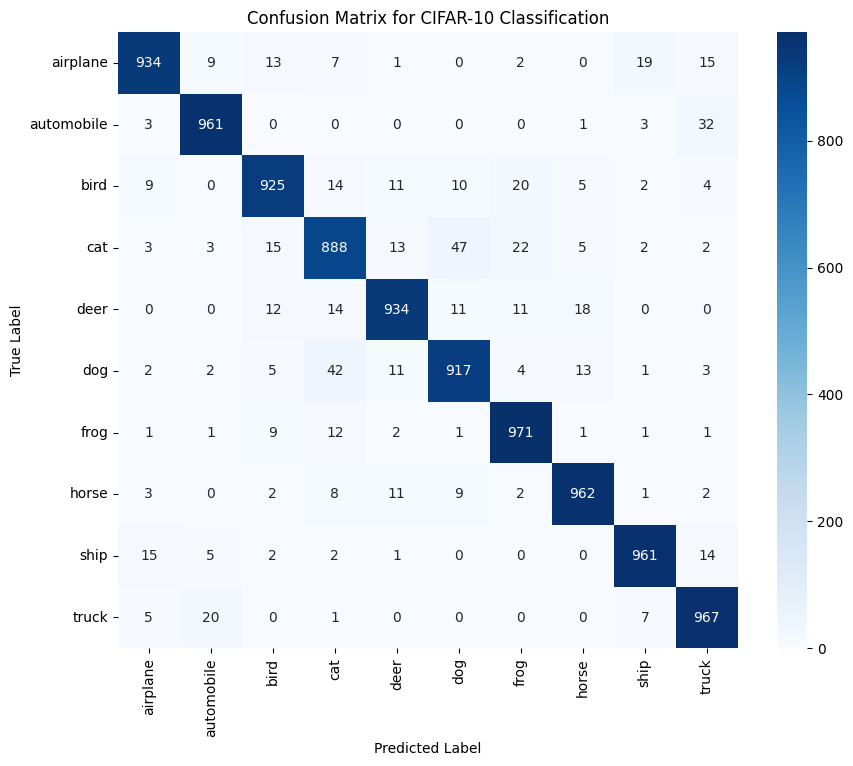

In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns # Added for visualization
from sklearn.metrics import classification_report, confusion_matrix # Added for evaluation
# --- 5. Final Evaluation and Prediction Display ---

print("\n" + "="*50)
print("FINAL EVALUATION (Loading Best Model)")
print("="*50)

# Load the best weights saved by the ModelCheckpoint callback
try:
    model.load_weights(CHECKPOINT_PATH)
    loss, accuracy = model.evaluate(x_test, y_test_one_hot, verbose=0)
    print(f"\nTest Accuracy (Best Checkpoint): {accuracy*100:.2f}%")


    # --- DETAILED EVALUATION AND VISUALIZATION ---

    print("\n--- Generating Detailed Classification Metrics ---")

    # 1. Get predictions (probabilities)
    y_pred_probs = model.predict(x_test)

    # 2. Convert probabilities to class indices (the actual predictions)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # 3. Get true class indices from the one-hot encoded labels
    y_true_classes = np.argmax(y_test_one_hot, axis=1)


    # A. CLASSIFICATION REPORT (Precision, Recall, F1-Score per class)
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_true_classes, y_pred_classes, target_names=CIFAR10_LABELS))


    # B. CONFUSION MATRIX (Visualization)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=CIFAR10_LABELS,
        yticklabels=CIFAR10_LABELS
    )
    plt.title('Confusion Matrix for CIFAR-10 Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

except Exception as e:
    print(f"An error occurred during model evaluation: {e}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step


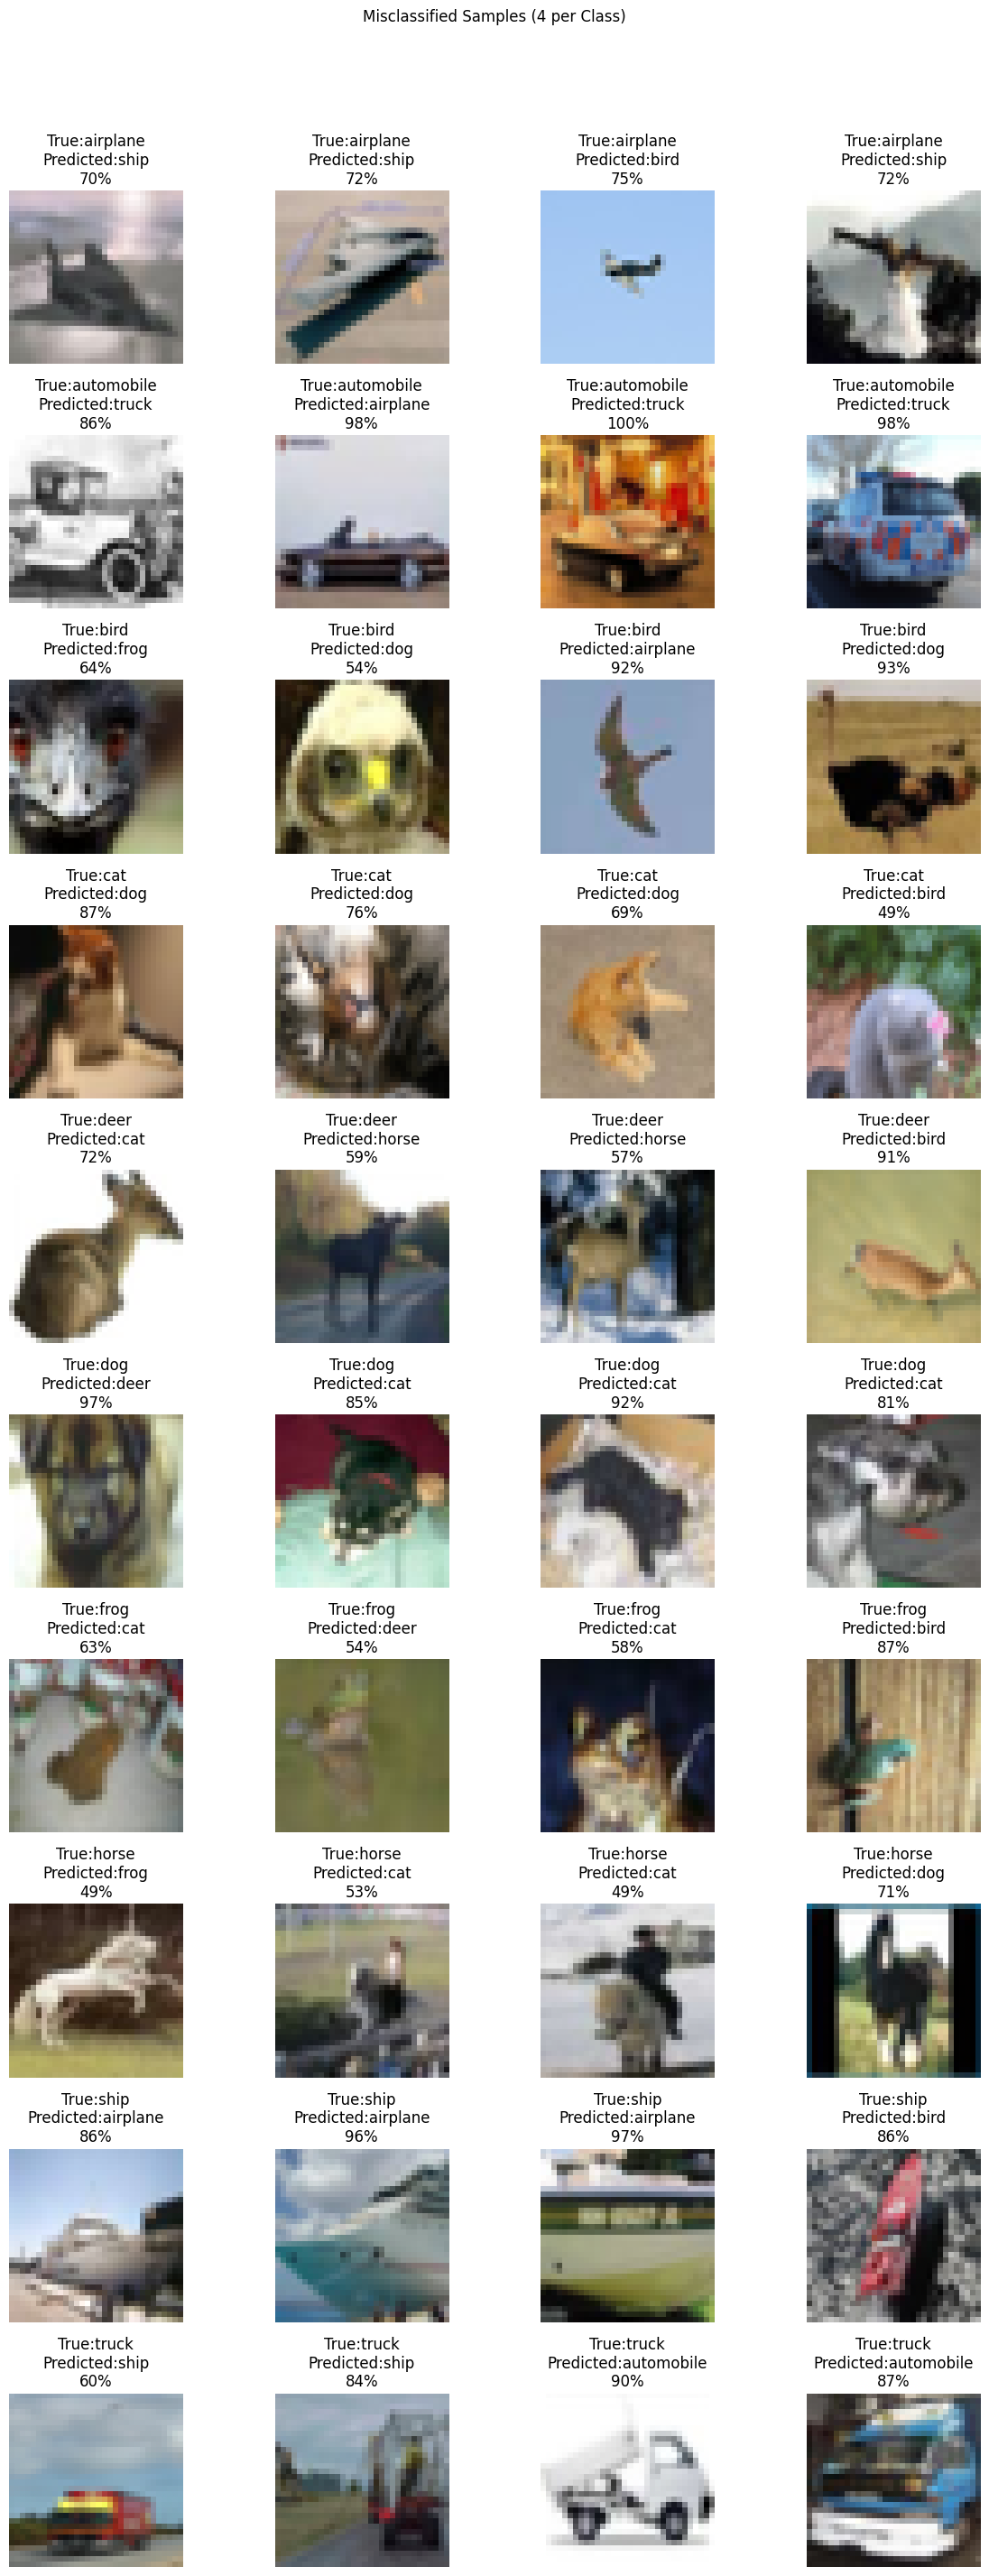

In [21]:
import matplotlib.pyplot as plt
import numpy as np

num_classes = len(CIFAR10_LABELS)
samples_per_class = 4

# Predict all test samples
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class*3, num_classes*3))
fig.suptitle("Misclassified Samples (4 per Class)")

for class_idx in range(num_classes):
    # Indices of all samples in this class
    class_indices = np.where(y_true_classes == class_idx)[0]
    # Misclassifications for this class
    misclassified_indices = [i for i in class_indices if y_pred_classes[i] != class_idx]

    # Pick up to 4 misclassified indices
    for j in range(samples_per_class):
        ax = axes[class_idx, j]
        if j < len(misclassified_indices):
            idx = misclassified_indices[j]
            true_label = CIFAR10_LABELS[class_idx]
            predicted_label = CIFAR10_LABELS[y_pred_classes[idx]]
            confidence = y_pred_probs[idx][y_pred_classes[idx]] * 100

            ax.imshow(x_test[idx])
            ax.set_title(f"True:{true_label}\nPredicted:{predicted_label}\n{confidence:.0f}%")
        else:
            ax.axis('off')  # Hide axes if fewer than 4 misclassifications
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


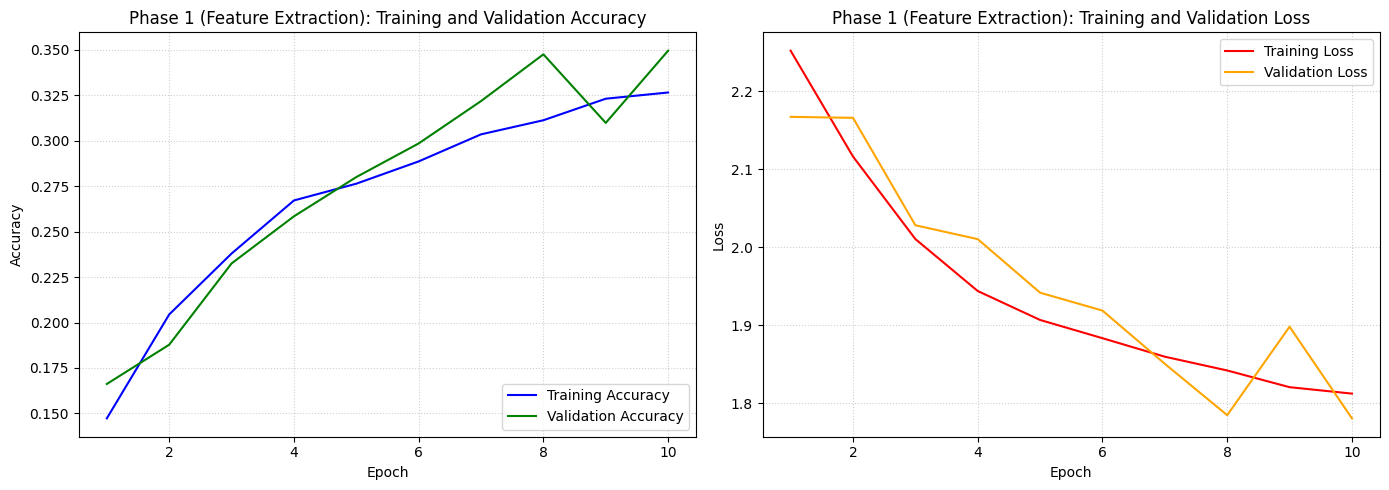

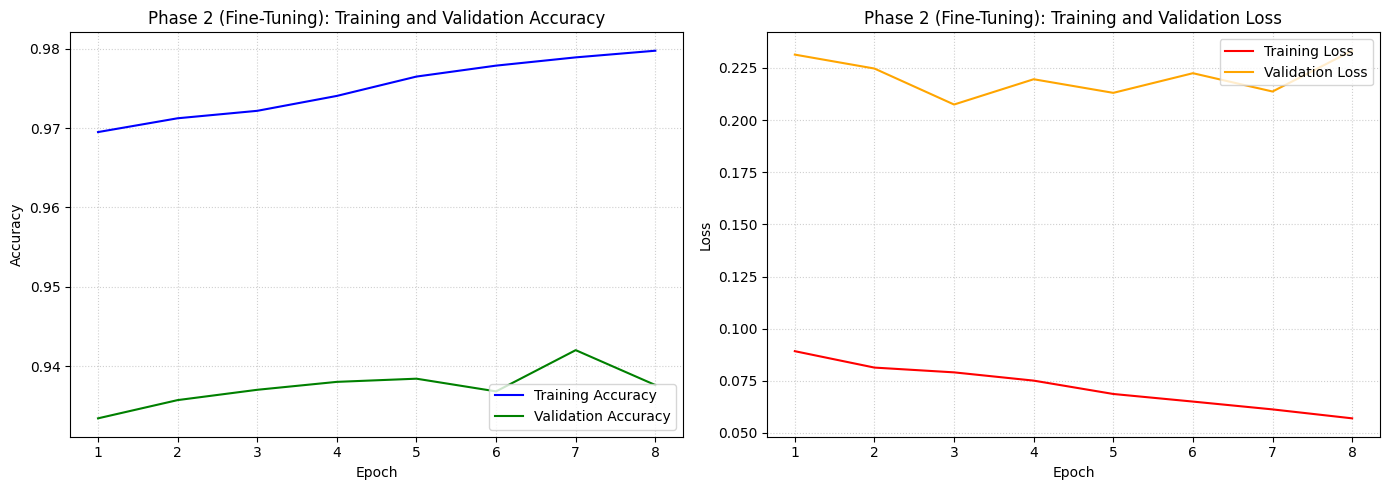

In [23]:
# --- 6. Plotting Training History ---

def plot_history(history, title):
    """Plots training and validation accuracy and loss for a single history object."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green')
    plt.legend(loc='lower right')
    plt.title(f'{title}: Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle=':', alpha=0.6)

    # Plot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='red')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.legend(loc='upper right')
    plt.title(f'{title}: Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Plot Phase 1 History
plot_history(history_phase1, "Phase 1 (Feature Extraction)")

# Plot Phase 2 History
plot_history(history_phase2, "Phase 2 (Fine-Tuning)")

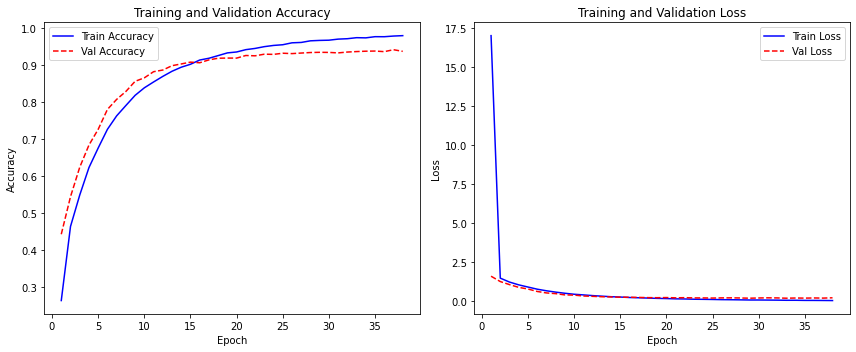

In [1]:
import matplotlib.pyplot as plt

# --- Store metrics from all epochs in lists ---
train_acc = [
    0.2631, 0.4636, 0.5486, 0.6230, 0.6760, 0.7265, 0.7630, 0.7910, 0.8185, 0.8389,
    0.8547, 0.8698, 0.8837, 0.8947, 0.9026, 0.9141, 0.9189, 0.9261, 0.9334, 0.9359,
    0.9422, 0.9455, 0.9503, 0.9536, 0.9555, 0.9607, 0.9617, 0.9661, 0.9672, 0.9678, # 1-30
    0.9707, 0.9718, 0.9746, 0.9741, 0.9773, 0.9772, 0.9790, 0.9801                  # 31-38
]
val_acc = [
    0.4426, 0.5442, 0.6239, 0.6840, 0.7266, 0.7804, 0.8076, 0.8290, 0.8565, 0.8659,
    0.8825, 0.8870, 0.8988, 0.9035, 0.9084, 0.9067, 0.9145, 0.9190, 0.9194, 0.9193,
    0.9264, 0.9255, 0.9299, 0.9294, 0.9325, 0.9315, 0.9330, 0.9344, 0.9350, 0.9347, # 1-30
    0.9334, 0.9357, 0.9370, 0.9380, 0.9384, 0.9368, 0.9420, 0.9376                  # 31-38
]
train_loss = [
    17.0225, 1.4923, 1.2402, 1.0616, 0.9223, 0.7849, 0.6824, 0.5970, 0.5230, 0.4608,
    0.4185, 0.3738, 0.3379, 0.3025, 0.2816, 0.2517, 0.2351, 0.2151, 0.1973, 0.1841,
    0.1651, 0.1580, 0.1411, 0.1355, 0.1267, 0.1152, 0.1096, 0.1017, 0.0921, 0.0922, # 1-30
    0.0877, 0.0826, 0.0742, 0.0748, 0.0668, 0.0655, 0.0616, 0.0566                  # 31-38
]
val_loss = [
    1.6158, 1.2728, 1.0769, 0.9008, 0.7955, 0.6391, 0.5448, 0.4996, 0.4187, 0.4058,
    0.3493, 0.3269, 0.3004, 0.2881, 0.2718, 0.2688, 0.2570, 0.2443, 0.2392, 0.2482,
    0.2318, 0.2422, 0.2255, 0.2245, 0.2166, 0.2272, 0.2300, 0.2218, 0.2071, 0.2215, # 1-30
    0.2314, 0.2247, 0.2075, 0.2196, 0.2131, 0.2225, 0.2137, 0.2333                  # 31-38
]
epochs = range(1, len(train_acc) + 1)

# --- Plot ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()
